In [23]:
import os

import numpy as np
import pandas as pd
import pickle 

from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score

# Plots
import matplotlib.pyplot as plt

# Prerocessing for FEDOT
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.api.main import Fedot
from fedot.core.repository.tasks import Task, TaskTypesEnum
# FEDOT 
from fedot.core.pipelines.pipeline import Pipeline

import logging
logging.raiseExceptions = False


In [24]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

## Dataset general preparation

In [25]:
df = None
with open("covid_flow.pkl", "rb") as f:
    df = pickle.load(f)
df["case"] = df.index
df["t_point"] = df["t_point"].apply(lambda x: x[2:])
df["t_point"] = df["t_point"].apply(lambda x: int(x))
df = df.set_index(["case", "t_point"])
df = df.sort_values(["case", "t_point"])
dynamic_idx = list(range(29, 42))
dynamic_columns = list(df.columns[dynamic_idx])
df.loc[:, dynamic_columns]

Температура_dinam_fact  Лимфоциты#_dinam_fact  \
case    t_point                                                  
GACAAcY 0                          36.7                   1.93   
        1                          36.3                   2.00   
        2                          36.6                   2.13   
        3                          36.5                   2.12   
GACAAnf 0                           NaN                   1.21   
...                                 ...                    ...   
GACBB;O 0                          36.9                   1.22   
        1                          36.5                   1.65   
GACXAAB 0                          36.5                   1.11   
        1                          36.9                   1.60   
        2                          36.6                   3.45   

                 АСТ_dinam_fact  ЧСС_dinam_fact  ЧДД_dinam_fact  \
case    t_point                                                   
GACAAcY 0                 27.90            74.0            24.0   
        1                 25.70            71.0            19.0   
        2                 32.00             NaN            18.0   
        3                 27.00            71.0            18.0   
GACAAnf 0                 20.70            55.0            22.0   
...                         ...             ...             ...   
GACBB;O 0                 22.34            54.0            18.0   
        1                244.03             NaN            17.0   
GACXAAB 0                 21.80             NaN             NaN   
        1                 60.80            75.0            16.0   
        2                 17.20             NaN            15.0   

                 Билирубин общий_dinam_fact  \
case    t_point                               
GACAAcY 0                             15.30   
        1                             12.10   
        2                               NaN   
        3                               NaN   
GACAAnf 0                              7.80   
...                                     ...   
GACBB;O 0                              1.43   
        1                              3.78   
GACXAAB 0                              4.50   
        1                              1.10   
        2                              9.30   

                 MPV- Средн.объем тромбоцитов_dinam_fact  \
case    t_point                                            
GACAAcY 0                                           11.2   
        1                                           10.6   
        2                                           11.0   
        3                                           11.4   
GACAAnf 0                                            8.1   
...                                                  ...   
GACBB;O 0                                            7.0   
        1                                            7.2   
GACXAAB 0                                           10.6   
        1                                           10.8   
        2                                           10.0   

                 PCT- Тромбокрит_dinam_fact  Лимфоциты%_dinam_fact  \
case    t_point                                                      
GACAAcY 0                             0.100                   48.3   
        1                             0.160                   30.7   
        2                             0.190                   23.1   
        3                             0.100                   24.1   
GACAAnf 0                             0.201                   24.1   
...                                     ...                    ...   
GACBB;O 0                             0.134                   33.0   
        1                             0.210                   41.2   
GACXAAB 0                             0.200                   18.8   
        1                             0.270                   12.9   
        2                             0.280          

#### Divide it on blocks

We will take from one to four last records and predict next vector

In [26]:
full_df = df.copy()
full_df

омепразол_stat_control  надропарин кальция_stat_control  \
case    t_point                                                            
GACAAcY 0                             1                                1   
        1                             1                                1   
        2                             1                                1   
        3                             1                                1   
GACAAnf 0                             1                                1   
...                                 ...                              ...   
GACBB;O 0                             0                                0   
        1                             0                                0   
GACXAAB 0                             1                                0   
        1                             1                                0   
        2                             1                                0   

                 эзомепразол_stat_control  амлодипин_stat_control  \
case    t_point                                                     
GACAAcY 0                               1                       1   
        1                               1                       1   
        2                               1                       1   
        3                               1                       1   
GACAAnf 0                               1                       1   
...                                   ...                     ...   
GACBB;O 0                               0                       1   
        1                               0                       1   
GACXAAB 0                               1                       1   
        1                               1                       1   
        2                               1                       1   

                 амброксол_stat_control  домперидон_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                             1                        1   
GACAAnf 0                             1                        1   
...                                 ...                      ...   
GACBB;O 0                             1                        0   
        1                             1                        0   
GACXAAB 0                             0                        1   
        1                             0                        1   
        2                             0                        1   

                 меброфенин_stat_control  технеций_stat_control  \
case    t_point                                                   
GACAAcY 0                              1                      1   
        1                              1                      1   
        2                              1                      1   
        3                              1                      1   
GACAAnf 0                              1                      1   
...                                  ...                    ...   
GACBB;O 0                              0                      0   
        1                              0                      0   
GACXAAB 0                              1                      1   
        1                              1                      1   
        2                              1                      1   

                 мометазон_stat_control  бисопролол_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                        

Exclude columns, which give information about how long the treatment was performed and about result

In [27]:
df = df.drop(["end_epizode", "admission_date", "current_process_duration", "process_stages", "outcome_tar", "long_observation_tar"], axis=1)

In [28]:
df.loc[df.index.levels[0][1]]

,омепразол_stat_control,надропарин кальция_stat_control,эзомепразол_stat_control,амлодипин_stat_control,амброксол_stat_control,домперидон_stat_control,меброфенин_stat_control,технеций_stat_control,мометазон_stat_control,бисопролол_stat_control,дексаметазон_stat_control,гидрохлоротиазид_stat_control,гидроксихлорохин_stat_control,рабепразол_stat_control,эноксапарин натрия_stat_control,периндоприл_stat_control,ацетилцистеин_stat_control,азитромицин_stat_control,валсартан_stat_control,метилпреднизолон_stat_control,лоратадин_stat_control,хлорохин_stat_control,натрия хлорид_stat_control,индапамид_stat_control,преднизолон_stat_control,аторвастатин_stat_control,декстран_stat_control,лизиноприл_stat_control,лозартан_stat_control,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact,age_stat_fact,трансфузия_dinam_control,оксигенотерапия_dinam_control,НИВЛ_dinam_control,ИВЛ_dinam_control
t_point,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,NaN,1.21,20.7,55.0,22.0,7.8,8.1,0.201,24.1,0,1,189.0,17.7,73,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,NaN,2.09,21.0,72.0,18.0,8.8,7.0,0.204,33.2,0,5,NaN,19.8,73,0,0,0,0


Проверим, менялись ли процедуры или нет за время лечения пациентов

In [30]:
t = df.groupby(level=0).nunique().iloc[:, 42:]
pd.DataFrame(t.value_counts())

0
age_stat_fact трансфузия_dinam_control оксигенотерапия_dinam_control НИВЛ_dinam_control ИВЛ_dinam_control      
1             1                        1                             1                  1                  1619
                                       2                             1                  1                   184
                                       1                             1                  2                    61
              2                        1                             1                  2                    34
                                                                                        1                    30
              1                        1                             2                  2                    12
              2                        1                             2                  2                    10
              1                        2                             1                  2                     9
                                       1                             2                  1                     8
              2                        2                             1                  1                     6
                                                                                        2                     6
                                       1                             2                  1                     5
              1                        2                             2                  1                     3
              2                        2                             2                  2                     3
              1                        2                             2                  2                     2

Проверим, что лекарства не менялись во время лечения пациентов

In [31]:
t = df.groupby(level=0).nunique().iloc[:, :29]
pd.DataFrame(t.value_counts())

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0
омепразол_stat_control,надропарин кальция_stat_control,эзомепразол_stat_control,амлодипин_stat_control,амброксол_stat_control,домперидон_stat_control,меброфенин_stat_control,технеций_stat_control,мометазон_stat_control,бисопролол_stat_control,дексаметазон_stat_control,гидрохлоротиазид_stat_control,гидроксихлорохин_stat_control,рабепразол_stat_control,эноксапарин натрия_stat_control,периндоприл_stat_control,ацетилцистеин_stat_control,азитромицин_stat_control,валсартан_stat_control,метилпреднизолон_stat_control,лоратадин_stat_control,хлорохин_stat_control,натрия хлорид_stat_control,индапамид_stat_control,преднизолон_stat_control,аторвастатин_stat_control,декстран_stat_control,лизиноприл_stat_control,лозартан_stat_control,
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1992


По лекарствам у всех пациентов набор препаратов не менялся, а по процедурам у 380 пациентов изменялся порядок. Из этого сделаем вывод, что можно выделить лекарства и возраст в один вектор, а процедуры не разбираем

Уберем всех пациентов лечившихся меньше 1 недели - они не дадут информации о развити заболевания


In [32]:
s = df.groupby(level=0).size()
df = df.loc[s[s>1].index.values]

Отделим части для обучения и тестирования

### Лимфоциты
Меня интересует зависимость параметров Лимфоциты# и Лимфоциты%. Проанализируем их

Text(0.5, 1.0, 'Зависимость распределения \n Лимфоциты% от Лимфоциты#')

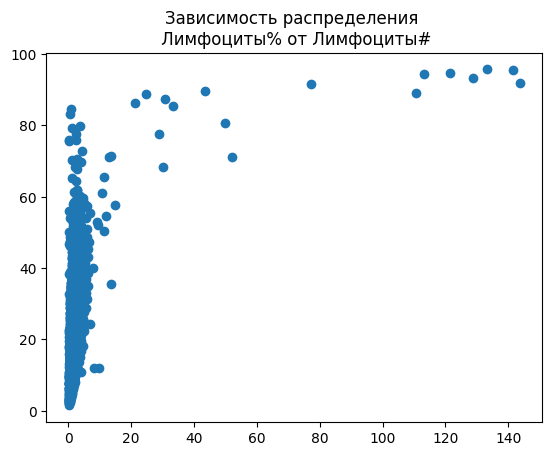

In [34]:
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
plt.scatter(data[:,0], data[:, 1])
plt.title("Зависимость распределения \n Лимфоциты% от Лимфоциты#")

Text(0.5, 1.0, 'Распределение величины Лимфоциты#_dinam_fact')

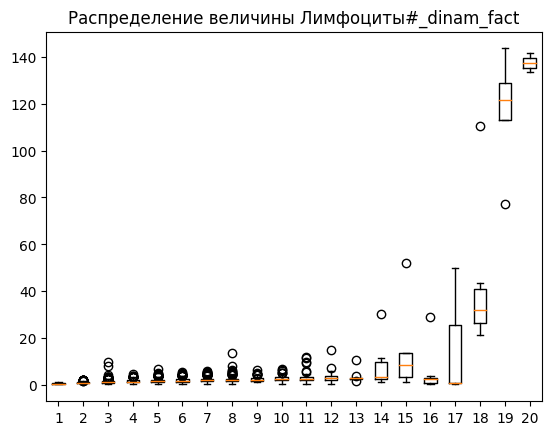

In [35]:
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
data = [df[(df["Лимфоциты%_dinam_fact"]>i) & (df["Лимфоциты%_dinam_fact"]<i+5)]["Лимфоциты#_dinam_fact"] for i in range(0, 100, 5)]
plt.boxplot(data)
plt.title("Распределение величины Лимфоциты#_dinam_fact")

Text(0.5, 1.0, 'Распределение величины Лимфоциты%_dinam_fact')

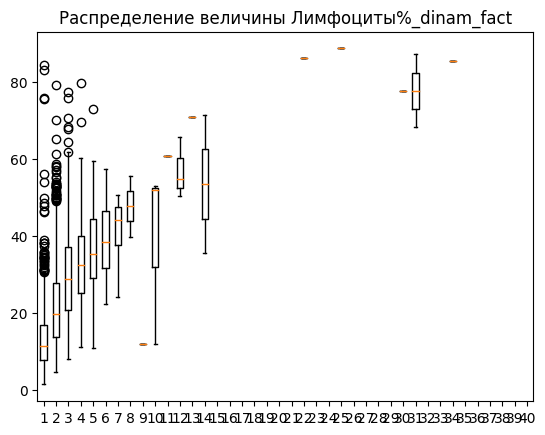

In [36]:
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
data = [df[(df["Лимфоциты#_dinam_fact"]>i) & (df["Лимфоциты#_dinam_fact"]<i+1)]["Лимфоциты%_dinam_fact"] for i in range(0, 40, 1)]
plt.boxplot(data)
plt.title("Распределение величины Лимфоциты%_dinam_fact")

Получается, что чистой корреляции у них нет. Однако чем выше количество лимфоцитов, тем больше их часть среди других лейкоцитов. Корреляцию Пирсона получаем 0.35 (P < 1e-159)

In [37]:
from scipy.stats import pearsonr
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
data = data[~np.isnan(data[:, 0]) & ~np.isnan(data[:, 1]) , :]
pearsonr(data[:, 0], data[:, 1])

PearsonRResult(statistic=0.35366027434981473, pvalue=5.609278436072053e-159)

Получили, что зависимость есть, но она не линейная, так что нужно оставить оба параметра

### Распределения параметров

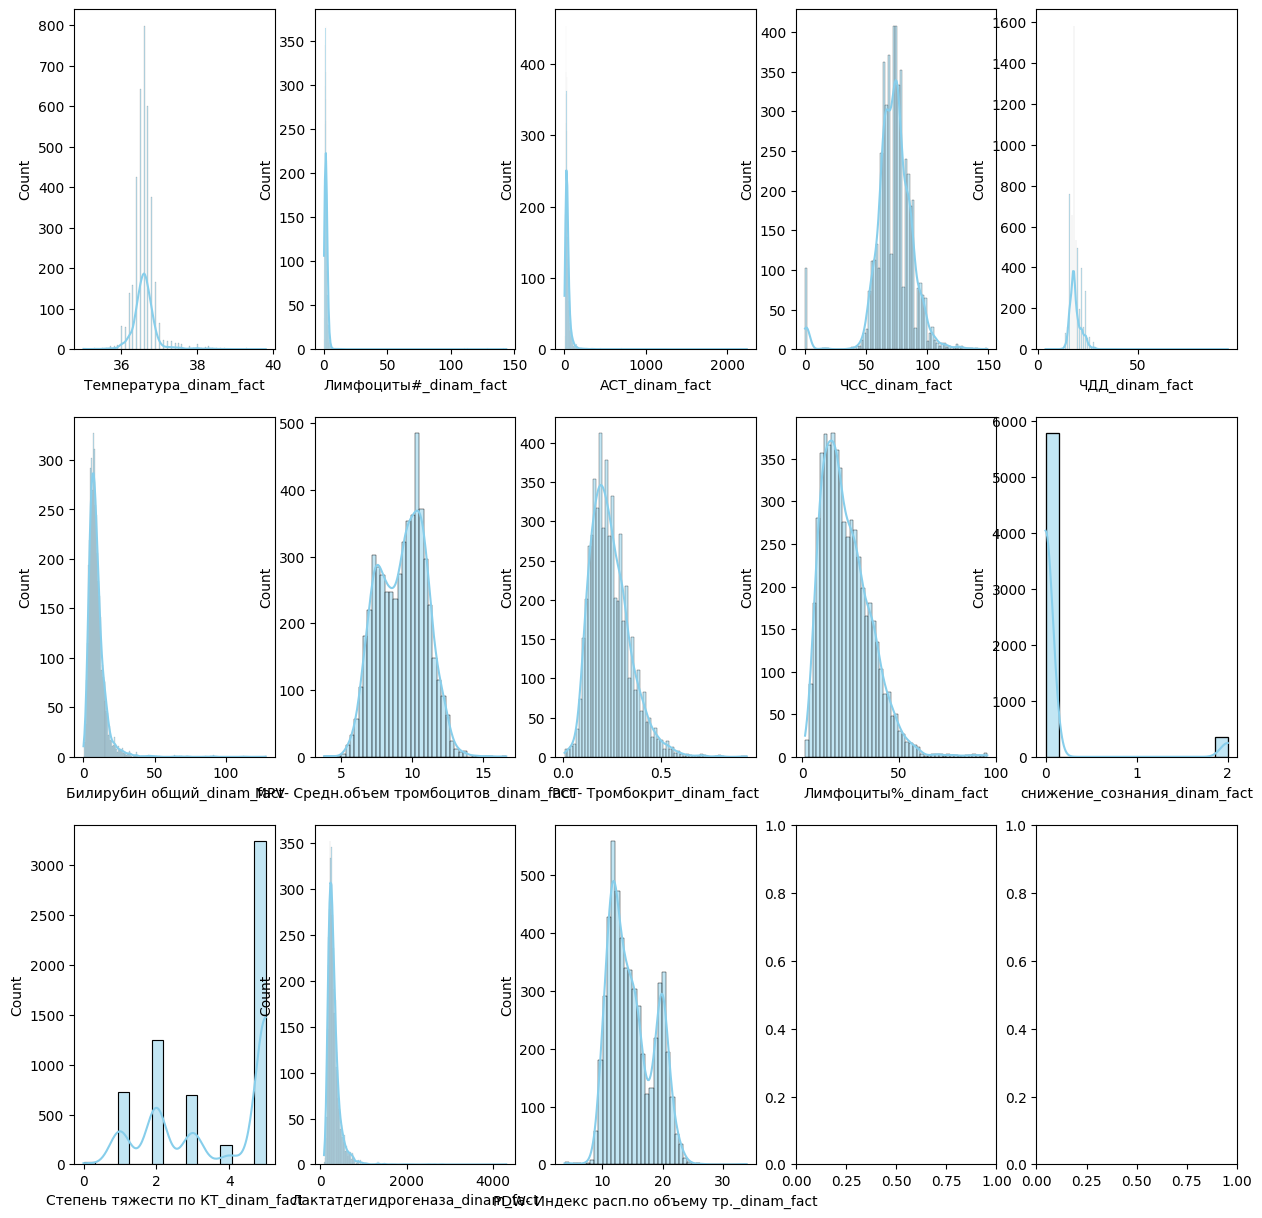

In [180]:
import seaborn as sns
figure, ax = plt.subplots(3, 5, figsize=(15, 15))
for i in range(13):
    sns.histplot(df.iloc[:, 29+i], color="skyblue", kde=True, ax=ax[i//5, i%5])

## Обучение

Теперь разделим датасет на окна - одна запись как фича, следующая за ней как таргет. И среди всех записей пациента проведем такую операцию

In [184]:
X , y = [], []
for i in df_train.index.levels[0]:
    try:
        for j in range(df_train.loc[i].index.size - 1):
            try:
                X.append(df_train.loc[(i, j)])
                y.append(df_train.loc[(i, j+1)].iloc[29:42])
            except:
                pass
    except:
        pass
X, y = np.array(X), np.array(y)

In [185]:
X[0]

array([1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
       1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 3.67e+01,
       1.93e+00, 2.79e+01, 7.40e+01, 2.40e+01, 1.53e+01, 1.12e+01,
       1.00e-01, 4.83e+01, 0.00e+00, 2.00e+00, 2.45e+02, 1.40e+01,
       8.10e+01, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00])

In [186]:
y[0]

array([3.63e+01, 2.00e+00, 2.57e+01, 7.10e+01, 1.90e+01, 1.21e+01,
       1.06e+01, 1.60e-01, 3.07e+01, 0.00e+00, 2.00e+00, 3.15e+02,
       1.28e+01])

Выберем значения таргета без nan, и каждому из 13-ти параметров соотнесем пары - вектор параметров X и значение Y параметра на следующей неделе. 

In [187]:
data = {param: [] for param in dynamic_columns}
for i in range(len(data)):
    X_temp, y_temp = [], []
    for j in range(y.shape[0]):
        if not np.isnan(y[j][i]):
            X_temp.append(X[j])
            y_temp.append(y[j][i])
    data[dynamic_columns[i]] = {"X": np.array(X_temp), "y": np.array(y_temp)}

In [195]:
data['Лимфоциты#_dinam_fact']["X"][0]

array([1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
       1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 3.67e+01,
       1.93e+00, 2.79e+01, 7.40e+01, 2.40e+01, 1.53e+01, 1.12e+01,
       1.00e-01, 4.83e+01, 0.00e+00, 2.00e+00, 2.45e+02, 1.40e+01,
       8.10e+01, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00])

In [196]:
data['Лимфоциты#_dinam_fact']["y"][0]

2.0

Теперь посмотрим, сколько пар для обучения у нас присутствует

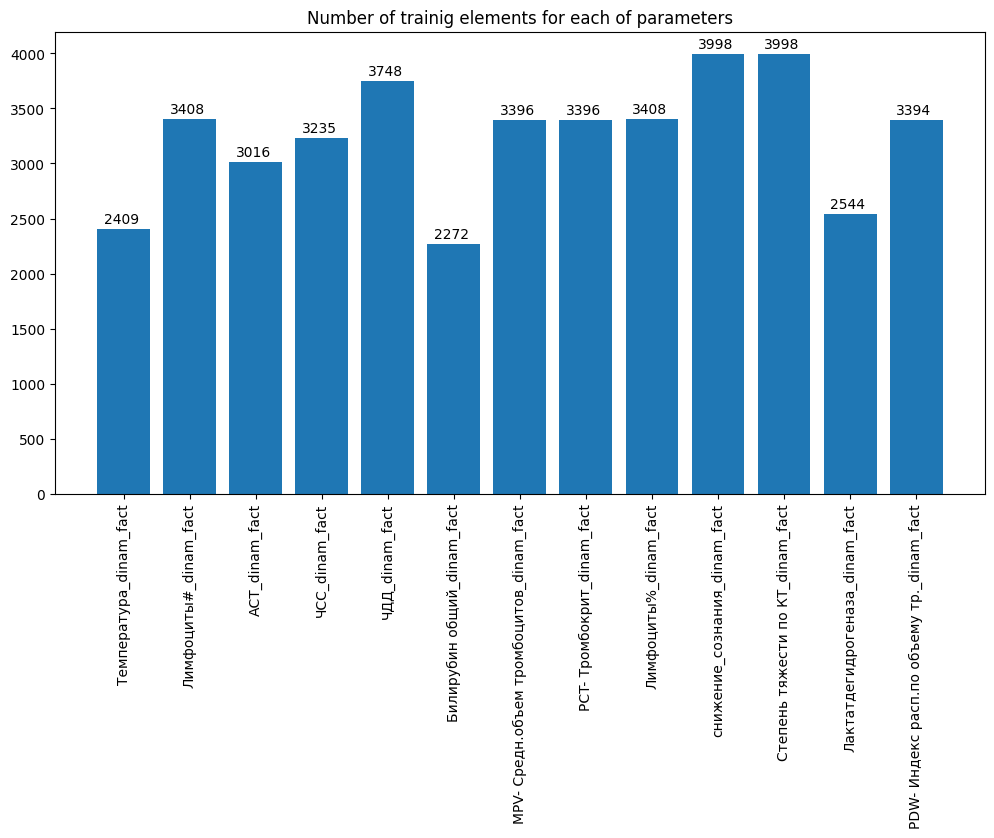

In [40]:
stat_nan = {k:len(data[k]["X"]) for k in data}
l = stat_nan.keys()
h = stat_nan.values()
plt.figure(figsize=(12, 6))
plt.bar(x=l, height=h)
plt.xticks(rotation=90)
plt.title("Number of trainig elements for each of parameters")
for key_idx, key in enumerate(stat_nan):
  plt.text(key_idx-0.3,stat_nan[key]+50,stat_nan[key])

Нам важно измерить качество регрессии. Будем вычислять R2, MSE, mAPE и 95% интервалы этих метрик. Для доверительных интервалов будем использовать значения метрик модели на 5 фолдах (иными словами кросс валидацию)

In [164]:
import scipy.stats as st

# Calculate R2, MSE, MAPE
def get_scores(y_real, y_pred):
    scores = {}
    scores["r2"] = r2_score(y_real, y_pred, multioutput="raw_values")
    scores["mse"] = mean_squared_error(y_real, y_pred, multioutput="raw_values")
    scores["mape"] = mean_absolute_percentage_error(y_real, y_pred, multioutput="raw_values")
    return scores

from fedot.core.validation.split import  tabular_cv_generator #used to split on folds

# Here we use composed pipeline to cross-validate it. I use 5-fold cross validation
def evaluate_with_intervals(model, X=None, y=None, folds=5, fedot=False):
    scoring_results = {"r2":[], "mape":[], "mse":[]}
    kf = KFold(folds)
    k = 0
    if (fedot):
        for train, test in kf.split(X, y): 
            indata_train = InputData(idx=np.arange(0, X[train].shape[0]), 
              features=X[train],
              target=y[train],
              data_type=DataTypesEnum.table,
              task=Task(TaskTypesEnum.regression))
            model.fit(indata_train)
            indata_test = InputData(idx=np.arange(0, X[test].shape[0]), 
              features=pd.DataFrame(X[test]),
              data_type=DataTypesEnum.table,
              task=Task(TaskTypesEnum.regression))
            y_pred = model.predict(indata_test).predict
            validation_data = get_scores(y[test], y_pred)
            for sc in scoring_results:
                scoring_results[sc].append(validation_data[sc])
            k+=1
    else:
        for train, test in kf.split(X, y):
            model.fit(X[train], y[train])
            y_pred = model.predict(X[test])
            validation_data = get_scores( y[test], y_pred)
            for sc in scoring_results:
                scoring_results[sc].append(validation_data[sc])
            k+=1
    data_df = {}
    for metric in scoring_results:
        dataz = scoring_results[metric]
        interval  = st.t.interval(confidence=0.95 , df=len(dataz), loc=np.mean(dataz), scale=st.sem(dataz)) #95% interval
        data_df["max_"+metric] = interval[1]
        data_df["min_"+metric] = interval[0]
        data_df["avg_"+metric] = (interval[1]+interval[0])/2
    df_metrics = pd.DataFrame(data_df, index=[0])
    return df_metrics



Чтобы обьективно понимать, что будущие модели будут улавливать закономерности а не рандомно делать свои ответы, попробуем возвращать только среднее значение параметра по всем возможным наблюдениям и после сравним эффективность такого подхода с моделью машинного обучения

### HistGradientBoostingRegressor

Сделаем модели на каждый параметр с простенькой моделью HistGradientBoostingRegressor (она единственная из sklearn ргегрессоров поддерживает NaN)

In [198]:
from sklearn.ensemble import HistGradientBoostingRegressor

result_table = pd.DataFrame()
parameters_validation = []
for col in list(data.keys()):
    X_param, y_param = data[col]["X"], data[col]["y"]
    model = HistGradientBoostingRegressor()
    metrs = evaluate_with_intervals(model, X_param, y_param) # fedot=True for InputData using instead of direct parameters
    metrs["parameter"] = col
    metrs["model"] = "HistGradientBoostingRegressor"
    parameters_validation.append(metrs)
    print(f"Successfully processed {col} \n")

Model fitted on fold 0 / 5
Model fitted on fold 1 / 5
Model fitted on fold 2 / 5
Model fitted on fold 3 / 5
Model fitted on fold 4 / 5
Successfully processed Температура_dinam_fact 

Model fitted on fold 0 / 5
Model fitted on fold 1 / 5
Model fitted on fold 2 / 5
Model fitted on fold 3 / 5
Model fitted on fold 4 / 5
Successfully processed Лимфоциты#_dinam_fact 

Model fitted on fold 0 / 5
Model fitted on fold 1 / 5
Model fitted on fold 2 / 5
Model fitted on fold 3 / 5
Model fitted on fold 4 / 5
Successfully processed АСТ_dinam_fact 

Model fitted on fold 0 / 5
Model fitted on fold 1 / 5
Model fitted on fold 2 / 5
Model fitted on fold 3 / 5
Model fitted on fold 4 / 5
Successfully processed ЧСС_dinam_fact 

Model fitted on fold 0 / 5
Model fitted on fold 1 / 5
Model fitted on fold 2 / 5
Model fitted on fold 3 / 5
Model fitted on fold 4 / 5
Successfully processed ЧДД_dinam_fact 

Model fitted on fold 0 / 5
Model fitted on fold 1 / 5
Model fitted on fold 2 / 5
Model fitted on fold 3 / 5
Mo

In [199]:
pd.concat(parameters_validation)

,max_r2,min_r2,avg_r2,max_mape,min_mape,avg_mape,max_mse,min_mse,avg_mse,parameter,model
0,-0.069213,-0.206247,-0.137730,5.577604e-03,4.695341e-03,5.136472e-03,0.089643,0.061523,0.075583,Температура_dinam_fact,HistGradientBoostingRegressor
0,0.975189,-0.659533,0.157828,4.556526e-01,3.734947e-01,4.145737e-01,14.139650,-4.487169,4.826240,Лимфоциты#_dinam_fact,HistGradientBoostingRegressor
0,0.626716,-1.712989,-0.543137,1.151331e+00,4.183200e-01,7.848253e-01,12100.562694,5889.099611,8994.831152,АСТ_dinam_fact,HistGradientBoostingRegressor
0,-0.068322,-0.121367,-0.094844,2.577899e+00,8.460319e-01,1.711966e+00,350.373914,215.986328,283.180121,ЧСС_dinam_fact,HistGradientBoostingRegressor
0,0.059771,-0.003266,0.028252,8.427894e-02,7.089102e-02,7.758498e-02,8.279868,2.876714,5.578291,ЧДД_dinam_fact,HistGradientBoostingRegressor
0,0.390767,0.218667,0.304717,5.185060e-01,3.735674e-01,4.460367e-01,60.172151,19.063624,39.617888,Билирубин общий_dinam_fact,HistGradientBoostingRegressor
0,0.900819,0.413710,0.657265,1.072134e-01,4.506701e-02,7.614020e-02,1.507406,0.286075,0.896740,MPV- Средн.объем тромбоцитов_dinam_fact,HistGradientBoostingRegressor
0,0.366069,0.228749,0.297409,3.646570e-01,2.775051e-01,3.210811e-01,0.008953,0.006417,0.007685,PCT- Тромбокрит_dinam_fact,HistGradientBoostingRegressor
0,0.407624,0.324771,0.366198,4.845369e-01,4.255743e-01,4.550556e-01,112.864122,81.193142,97.028632,Лимфоциты%_dinam_fact,HistGradientBoostingRegressor
0,0.968874,0.876736,0.922805,1.225776e+14,5.740608e+13,8.999185e+13,0.027148,0.006839,0.016993,снижение_сознания_dinam_fact,HistGradientBoostingRegressor


### Fedot

Построим пайплайны с помощью Fedot на каждый из параметров. 

Будем использовать таймаут 10 минут, так как при дальнейшем продолжении композиции качество не увеличивается на все параметрах

In [ ]:
# #takes a long time (about 2 hours), be careful!
# for col in list(data.keys()):
#     print(f"Start composing {col}")
#     model = Fedot(problem="regression", timeout=10, cache_folder="D:\\Cache") # I changed cache folder path as it tkaes up to 20Gb
#     X_param, y_param = data[col]["X"], data[col]["y"]
#     pipeline = model.fit(X_param, y_param)
#     pipeline.save(f"fedot_pipelines\\{col}", create_subdir=False, is_datetime_in_path=False)
#     print(f"Successfully composed {col} \n")

И построенные пайплайны с тюнеными параметрами оцениваем кросс-валидацией на тех же данных, что и строили


**с параметром Температура работает**

In [170]:
obtained_pipelines = []
for col in [list(data.keys())[0]]:
    print(f"Start fitting model for {col}")
    model = Fedot(problem="regression", timeout=1) 
    X_param, y_param = data[col]["X"], data[col]["y"]
    pipeline = model.fit(X_param, y_param)
    X_param, y_param = data[col]["X"], data[col]["y"]
    metrs = evaluate_with_intervals(pipeline, X_param, y_param, folds=5, fedot=True) # fedot=True for InputData using instead of direct parameters
    metrs["parameter"] = col
    metrs["model"] = "Fedot"
    print(f"Successfully processed {col} \n")

Start fitting model for Температура_dinam_fact
2023-04-05 11:08:11,825 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 4.8 MiB, max: 18.8 MiB
2023-04-05 11:08:11,828 - ApiComposer - Initial pipeline was fitted in 2.6 sec.
2023-04-05 11:08:11,829 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2023-04-05 11:08:11,838 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 1 min. Set of candidate models: ['isolation_forest_reg', 'sgdr', 'adareg', 'linear', 'svr', 'poly_features', 'ransac_lin_reg', 'ridge', 'normalization', 'treg', 'knnreg', 'pca', 'lgbmreg', 'fast_ica', 'rfr', 'dtreg', 'lasso', 'scaling', 'gbr', 'ransac_non_lin_reg', 'isolation_forest_reg', 'sgdr', 'adareg', 'linear', 'svr', 'poly_features', 'ransac_lin_reg', 'ridge', 'normalization', 'treg', 'knnreg', 'pca', 'lgbmreg', 'fast_ica', 'rfr', 'dtreg', 'lasso', 'scaling', 'gbr', 'ransac_non_lin_reg'].

Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2023-04-05 11:08:14,742 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-04-05 11:09:28,748 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-04-05 11:09:28,751 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                          | 1/10000 [01:16<?, ?gen/s]

2023-04-05 11:09:28,758 - ApiComposer - Time for pipeline composing was 0:01:16.884374.
The remaining 0.3 seconds are not enough to tune the hyperparameters.
2023-04-05 11:09:28,760 - ApiComposer - Composed pipeline returned without tuning.
2023-04-05 11:09:28,968 - ApiComposer - Model generation finished


2023-04-05 11:09:30,214 - FEDOT logger - Final pipeline was fitted
2023-04-05 11:09:30,216 - FEDOT logger - Final pipeline: {'depth': 1, 'length': 1, 'nodes': [rfr]}
rfr - {'n_jobs': -1, 'max_features': 0.29232920060203604, 'min_samples_split': 2, 'min_samples_leaf': 14, 'bootstrap': True}
Memory consumption for finish in main session: current 5.7 MiB, max: 18.8 MiB
Successfully processed Температура_dinam_fact 



**а на других параметрах не рабоатет**

In [169]:
for col in list(data.keys())[1:5]: 
    print(f"Start fitting model for {col}")
    model = Fedot(problem="regression", timeout=1) # I changed cache folder path as it tkaes up to 20Gb
    X_param, y_param = data[col]["X"], data[col]["y"]
    pipeline = model.fit(X_param, y_param)
    X_param, y_param = data[col]["X"], data[col]["y"]
    metrs = evaluate_with_intervals(pipeline, X_param, y_param, folds=5, fedot=True) # fedot=True for InputData using instead of direct parameters
    metrs["parameter"] = col
    metrs["model"] = "Fedot"
    print(f"Successfully processed {col} \n")



Start fitting model for Лимфоциты#_dinam_fact
2023-04-05 11:02:48,801 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 6.9 MiB, max: 36.9 MiB
2023-04-05 11:02:48,804 - ApiComposer - Initial pipeline was fitted in 3.0 sec.
2023-04-05 11:02:48,806 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2023-04-05 11:02:48,814 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 1 min. Set of candidate models: ['isolation_forest_reg', 'sgdr', 'adareg', 'linear', 'svr', 'poly_features', 'ransac_lin_reg', 'ridge', 'normalization', 'treg', 'knnreg', 'pca', 'lgbmreg', 'fast_ica', 'rfr', 'dtreg', 'lasso', 'scaling', 'gbr', 'ransac_non_lin_reg', 'isolation_forest_reg', 'sgdr', 'adareg', 'linear', 'svr', 'poly_features', 'ransac_lin_reg', 'ridge', 'normalization', 'treg', 'knnreg', 'pca', 'lgbmreg', 'fast_ica', 'rfr', 'dtreg', 'lasso', 'scaling', 'gbr', 'ransac_non_lin_reg'].


Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2023-04-05 11:03:04,242 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-04-05 11:04:08,742 - MultiprocessingDispatcher - 14 individuals out of 21 in previous population were evaluated successfully.
2023-04-05 11:04:08,745 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                          | 1/10000 [01:19<?, ?gen/s]

2023-04-05 11:04:08,753 - ApiComposer - Time for pipeline composing was 0:01:19.793923.
The remaining 0.4 seconds are not enough to tune the hyperparameters.
2023-04-05 11:04:08,755 - ApiComposer - Composed pipeline returned without tuning.


2023-04-05 11:04:09,072 - ApiComposer - Model generation finished
2023-04-05 11:04:09,847 - FEDOT logger - Final pipeline was fitted
2023-04-05 11:04:09,849 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [linear, scaling]}
linear - {}
scaling - {}
Memory consumption for finish in main session: current 8.7 MiB, max: 36.9 MiB


ValueError: X has 2 features, but SimpleImputer is expecting 1 features as input.

**но на 5ом параметре внезапно работает**

In [197]:
for col in [list(data.keys())[5]]:
    print(f"Start fitting model for {col}")
    model = Fedot(problem="regression", timeout=1) # I changed cache folder path as it tkaes up to 20Gb
    X_param, y_param = data[col]["X"], data[col]["y"]
    pipeline = model.fit(X_param, y_param)
    X_param, y_param = data[col]["X"], data[col]["y"]
    metrs = evaluate_with_intervals(pipeline, X_param, y_param, folds=5, fedot=True) # fedot=True for InputData using instead of direct parameters
    metrs["parameter"] = col
    metrs["model"] = "Fedot"
    print(f"Successfully processed {col} \n")

Start fitting model for Билирубин общий_dinam_fact
2023-04-05 11:17:25,903 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 4.5 MiB, max: 24.5 MiB
2023-04-05 11:17:25,906 - ApiComposer - Initial pipeline was fitted in 2.2 sec.
2023-04-05 11:17:25,907 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2023-04-05 11:17:25,913 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 1 min. Set of candidate models: ['isolation_forest_reg', 'sgdr', 'adareg', 'linear', 'svr', 'poly_features', 'ransac_lin_reg', 'ridge', 'normalization', 'treg', 'knnreg', 'pca', 'lgbmreg', 'fast_ica', 'rfr', 'dtreg', 'lasso', 'scaling', 'gbr', 'ransac_non_lin_reg', 'isolation_forest_reg', 'sgdr', 'adareg', 'linear', 'svr', 'poly_features', 'ransac_lin_reg', 'ridge', 'normalization', 'treg', 'knnreg', 'pca', 'lgbmreg', 'fast_ica', 'rfr', 'dtreg', 'lasso', 'scaling', 'gbr', 'ransac_non_lin_re

Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2023-04-05 11:17:32,873 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-04-05 11:18:22,993 - MultiprocessingDispatcher - 18 individuals out of 21 in previous population were evaluated successfully.
2023-04-05 11:18:22,996 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                          | 1/10000 [00:57<?, ?gen/s]

2023-04-05 11:18:23,007 - ApiComposer - Time for pipeline composing was 0:00:57.065888.
The remaining 0 seconds are not enough to tune the hyperparameters.
2023-04-05 11:18:23,008 - ApiComposer - Composed pipeline returned without tuning.


2023-04-05 11:18:23,340 - ApiComposer - Model generation finished
2023-04-05 11:18:23,959 - FEDOT logger - Final pipeline was fitted
2023-04-05 11:18:23,961 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [lasso, scaling]}
lasso - {}
scaling - {}
Memory consumption for finish in main session: current 5.4 MiB, max: 24.5 MiB
Successfully processed Билирубин общий_dinam_fact 



### А теперь перепишем функцию кросс-валидации, где не будем делить ни на какие фолды

In [204]:
def evaluate_with_intervals(model, X=None, y=None, folds=5, fedot=False):
    scoring_results = {"r2":[], "mape":[], "mse":[]}
    kf = KFold(folds)
    k = 0
    if (fedot):
        indata_train = InputData(idx=np.arange(0, X.shape[0]), 
          features=X,
          target=y,
          data_type=DataTypesEnum.table,
          task=Task(TaskTypesEnum.regression))
        model.fit(indata_train)
        indata_test = InputData(idx=np.arange(0, X.shape[0]), 
          features=X,
          data_type=DataTypesEnum.table,
          task=Task(TaskTypesEnum.regression))
        y_pred = model.predict(indata_test).predict
        validation_data = get_scores(y, y_pred)
        for sc in scoring_results:
            scoring_results[sc].append(validation_data[sc])
        k+=1
    else:
        for train, test in kf.split(X, y):
            model.fit(X[train], y[train])
            y_pred = model.predict(X[test])
            validation_data = get_scores( y[test], y_pred)
            for sc in scoring_results:
                scoring_results[sc].append(validation_data[sc])
            k+=1
    data_df = {}
    for metric in scoring_results:
        dataz = scoring_results[metric]
        interval  = st.t.interval(confidence=0.95 , df=len(dataz), loc=np.mean(dataz), scale=st.sem(dataz)) #95% interval
        data_df["max_"+metric] = interval[1]
        data_df["min_"+metric] = interval[0]
        data_df["avg_"+metric] = (interval[1]+interval[0])/2
    df_metrics = pd.DataFrame(data_df, index=[0])
    return df_metrics

и попробуем еще раз

In [205]:
for col in list(data.keys())[1:5]: 
    print(f"Start fitting model for {col}")
    model = Fedot(problem="regression", timeout=1) # I changed cache folder path as it tkaes up to 20Gb
    X_param, y_param = data[col]["X"], data[col]["y"]
    pipeline = model.fit(X_param, y_param)
    X_param, y_param = data[col]["X"], data[col]["y"]
    metrs = evaluate_with_intervals(pipeline, X_param, y_param, folds=5, fedot=True) # fedot=True for InputData using instead of direct parameters
    metrs["parameter"] = col
    metrs["model"] = "Fedot"
    print(f"Successfully processed {col} \n")

Start fitting model for Лимфоциты#_dinam_fact
2023-04-05 11:27:17,997 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 6.9 MiB, max: 36.8 MiB
2023-04-05 11:27:18,000 - ApiComposer - Initial pipeline was fitted in 3.1 sec.
2023-04-05 11:27:18,004 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2023-04-05 11:27:18,012 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 1 min. Set of candidate models: ['isolation_forest_reg', 'sgdr', 'adareg', 'linear', 'svr', 'poly_features', 'ransac_lin_reg', 'ridge', 'normalization', 'treg', 'knnreg', 'pca', 'lgbmreg', 'fast_ica', 'rfr', 'dtreg', 'lasso', 'scaling', 'gbr', 'ransac_non_lin_reg', 'isolation_forest_reg', 'sgdr', 'adareg', 'linear', 'svr', 'poly_features', 'ransac_lin_reg', 'ridge', 'normalization', 'treg', 'knnreg', 'pca', 'lgbmreg', 'fast_ica', 'rfr', 'dtreg', 'lasso', 'scaling', 'gbr', 'ransac_non_lin_reg'].


Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2023-04-05 11:27:21,911 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-04-05 11:28:33,813 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-04-05 11:28:33,817 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                          | 1/10000 [01:15<?, ?gen/s]

2023-04-05 11:28:33,824 - ApiComposer - Time for pipeline composing was 0:01:15.784888.
The remaining 0.3 seconds are not enough to tune the hyperparameters.
2023-04-05 11:28:33,825 - ApiComposer - Composed pipeline returned without tuning.


2023-04-05 11:28:34,062 - ApiComposer - Model generation finished
2023-04-05 11:28:34,858 - FEDOT logger - Final pipeline was fitted
2023-04-05 11:28:34,859 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [svr, scaling]}
svr - {}
scaling - {}
Memory consumption for finish in main session: current 8.0 MiB, max: 36.8 MiB
Successfully processed Лимфоциты#_dinam_fact 

Start fitting model for АСТ_dinam_fact
2023-04-05 11:28:39,936 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 6.1 MiB, max: 32.7 MiB
2023-04-05 11:28:39,940 - ApiComposer - Initial pipeline was fitted in 2.9 sec.
2023-04-05 11:28:39,941 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2023-04-05 11:28:39,948 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 1 min. Set of candidate models: ['isolation_forest_reg', 'sgdr', 'adareg', 'linear', 'svr', 'poly_features', 'ransac_li

Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2023-04-05 11:28:43,392 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-04-05 11:29:25,219 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-04-05 11:29:25,220 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                          | 1/10000 [00:45<?, ?gen/s]

2023-04-05 11:29:25,228 - ApiComposer - Time for pipeline composing was 0:00:45.257636.
The remaining 0.2 seconds are not enough to tune the hyperparameters.
2023-04-05 11:29:25,230 - ApiComposer - Composed pipeline returned without tuning.


2023-04-05 11:29:25,464 - ApiComposer - Model generation finished
2023-04-05 11:29:26,688 - FEDOT logger - Final pipeline was fitted
2023-04-05 11:29:26,690 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': -1, 'max_features': 0.12916334670985555, 'min_samples_split': 5, 'min_samples_leaf': 11, 'bootstrap': False}
scaling - {}
Memory consumption for finish in main session: current 7.2 MiB, max: 32.7 MiB
Successfully processed АСТ_dinam_fact 

Start fitting model for ЧСС_dinam_fact
2023-04-05 11:29:32,168 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 6.5 MiB, max: 31.8 MiB
2023-04-05 11:29:32,171 - ApiComposer - Initial pipeline was fitted in 3.3 sec.
2023-04-05 11:29:32,172 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2023-04-05 11:29:32,180 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 1 min. Se

Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2023-04-05 11:29:36,001 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-04-05 11:31:14,631 - MultiprocessingDispatcher - 19 individuals out of 21 in previous population were evaluated successfully.
2023-04-05 11:31:14,634 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                          | 1/10000 [01:42<?, ?gen/s]

2023-04-05 11:31:14,642 - ApiComposer - Time for pipeline composing was 0:01:42.440141.
The remaining 0.8 seconds are not enough to tune the hyperparameters.
2023-04-05 11:31:14,643 - ApiComposer - Composed pipeline returned without tuning.


2023-04-05 11:31:14,882 - ApiComposer - Model generation finished
2023-04-05 11:32:33,717 - FEDOT logger - Final pipeline was fitted
2023-04-05 11:32:33,721 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 5, 'nodes': [rfr, scaling, ransac_lin_reg, ransac_non_lin_reg, isolation_forest_reg]}
rfr - {'n_jobs': -1}
scaling - {}
ransac_lin_reg - {'min_samples': 0.4, 'residual_threshold': 10, 'max_trials': 100, 'max_skips': 1000}
ransac_non_lin_reg - {'min_samples': 0.4, 'residual_threshold': 10240, 'max_trials': 100, 'max_skips': 1000}
isolation_forest_reg - {}
Memory consumption for finish in main session: current 7.9 MiB, max: 170.0 MiB
Successfully processed ЧСС_dinam_fact 

Start fitting model for ЧДД_dinam_fact
2023-04-05 11:32:39,707 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 7.5 MiB, max: 25.2 MiB
2023-04-05 11:32:39,710 - ApiComposer - Initial pipeline was fitted in 3.2 sec.
2023-04-05 11:32:39,712 - AssumptionsHandl

Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2023-04-05 11:32:43,568 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-04-05 11:34:04,341 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-04-05 11:34:04,345 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                          | 1/10000 [01:24<?, ?gen/s]

2023-04-05 11:34:04,352 - ApiComposer - Time for pipeline composing was 0:01:24.607513.
The remaining 0.5 seconds are not enough to tune the hyperparameters.
2023-04-05 11:34:04,353 - ApiComposer - Composed pipeline returned without tuning.


2023-04-05 11:34:04,605 - ApiComposer - Model generation finished
2023-04-05 11:34:06,489 - FEDOT logger - Final pipeline was fitted
2023-04-05 11:34:06,491 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': -1, 'max_features': 0.26933039823741783, 'min_samples_split': 17, 'min_samples_leaf': 3, 'bootstrap': True}
scaling - {}
Memory consumption for finish in main session: current 8.9 MiB, max: 25.2 MiB
Successfully processed ЧДД_dinam_fact 



теперь все работает)

## Готовая модель
Здесь мы берем вектор текущих значений и последовательно всеми моделями предсказываем параметры

In [109]:
df_test = None
with open("covid_flow.pkl", "rb") as f:
    df_test = pickle.load(f)
df_test["case"] = df_test.index
df_test["t_point"] = df_test["t_point"].apply(lambda x: x[2:])
df_test["t_point"] = df_test["t_point"].apply(lambda x: int(x))
df_test = df_test.set_index(["case", "t_point"])
df_test = df_test.sort_values(["case", "t_point"])
df_test = df_test.iloc[:, :-6]
df_test.to_csv("covid_flow_test.csv")

In [113]:
import os
models = os.listdir("fedot_pipelines")
res = {}
df_pred = pd.read_csv("covid_flow_test.csv")
state_vector = df_pred.groupby("case").last()

input_data = InputData(idx=state_vector.index, 
          features=state_vector, 
          data_type=DataTypesEnum.table,
          task=Task(TaskTypesEnum.regression)
         )

pipelines = {}
for model in models:
    pipeline = Pipeline()
    pipeline.load(f"fedot_pipelines_april/{model}/{model}.json")
    pipelines[model] = pipeline

prediction_vector = {}
for model in models:
    prediction_vector[model] = pipelines[model].predict(input_data).predict

# Categorical features
result = pd.DataFrame(prediction_vector)
result.loc[:, "снижение_сознания_dinam_fact"] = result["снижение_сознания_dinam_fact"].apply(lambda x: int(x))
result.loc[:, "Cтепень тяжести по КТ_dinam_fact"] = result["Cтепень тяжести по КТ_dinam_fact"].apply(lambda x: int(x))
result


C:\Users\sirau\AppData\Local\Temp\ipykernel_18648\2315768102.py:25: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  result.loc[:, "снижение_сознания_dinam_fact"] = result["снижение_сознания_dinam_fact"].apply(lambda x: int(x))
C:\Users\sirau\AppData\Local\Temp\ipykernel_18648\2315768102.py:26: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  result.loc[:, "Cтепень тяжести по КТ_dinam_fact"] = result["Cтепень тяжести по КТ_dinam_fact"].apply(lambda x: int(x))


,Cтепень тяжести по КТ_dinam_fact,MPV- Средн,PCT- Тромбокрит_dinam_fact,PDW- Индекс расп.по объему тр,АСТ_dinam_fact,Билирубин общий_dinam_fact,Лактатдегидрогеназа_dinam_fact,Лимфоциты#_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Температура_dinam_fact,ЧДД_dinam_fact,ЧСС_dinam_fact
0,4,10.484670,0.426379,19.989427,71.037622,27.893488,242.034955,31.4739,21.047,0,36.555054,18.285308,70.388403
1,4,9.076119,0.431977,19.508176,76.545647,23.449568,230.588356,27.4664,22.949,0,36.555054,18.538296,71.789489
2,4,7.908733,0.382579,19.166321,77.402444,26.216675,230.557088,27.1759,24.632,0,36.555054,18.691578,70.974182
3,4,11.642310,0.408423,19.752500,72.178914,27.321833,245.660825,29.7954,22.246,0,36.555054,18.184847,71.475092
4,4,8.095603,0.379879,19.216131,82.737148,29.964315,230.293717,28.7912,24.393,0,36.555054,18.444508,71.562158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,4,7.880028,0.382579,19.174636,76.942369,21.658008,230.081140,27.0265,24.480,0,36.555054,18.555603,71.640981
1988,4,8.072296,0.382579,19.245525,76.741001,33.056502,230.496630,27.0265,26.629,0,36.555054,18.938909,72.146455
1989,4,8.113531,0.386250,19.435683,79.932451,32.013713,233.713946,28.3687,24.380,0,36.555054,18.309882,74.243142
1990,4,8.176252,0.391378,19.593431,80.478748,29.492354,228.351553,29.0936,26.146,0,36.555054,18.908182,76.260474
